In [75]:
# Allow notebook to import from sibling folder
import sys, os
import pandas as pd
sys.path.append(os.path.abspath(".."))
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA

In [76]:
#1. Load the Preprocessed data
df_formodel = pd.read_csv("../Data_Preprocessing/cleaned_data.csv")


In [77]:
# Separate columns by type
categorical_cols = ['Gender', 'Education_Level', 'Home_Ownership', 'Loan_Purpose']
numeric_cols = ['Credit_Score', 'Age', 'Annual_Income', 'Employment_Years', 'Loan_Amount', 'Loan_Interest_Rate',
                'Loan_Percentage_Income', 'Credit_History_Length', 'Previous_Loan_Defaults']

# One-hot encode categorical columns (excluding high-cardinality ones)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_formodel[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=df_formodel.index)

# Concatenate scaled numeric + encoded categorical
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df_formodel[numeric_cols])
scaled_df = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df_formodel.index)

# Final processed dataset
df_processed = pd.concat([scaled_df, encoded_df], axis=1)

print(df_processed.shape)
print(df_processed.head())

(45000, 22)
   Credit_Score       Age  Annual_Income  Employment_Years  Loan_Amount  \
0     -1.419814 -0.953538      -0.104090         -0.892284     4.024953   
1     -2.549975 -1.118963      -0.846005         -0.892284    -1.359209   
2      0.047412 -0.457264      -0.844065         -0.397517    -0.646600   
3      0.840507 -0.788113      -0.007039         -0.892284     4.024953   
4     -0.924130 -0.622689      -0.176371         -0.727362     4.024953   

   Loan_Interest_Rate  Loan_Percentage_Income  Credit_History_Length  \
0            1.683039                4.016394              -0.739109   
1            0.044782               -0.684829              -0.996863   
2            0.625557                3.443074              -0.739109   
3            1.417829                3.443074              -0.996863   
4            1.095549                4.475050              -0.481354   

   Previous_Loan_Defaults  Gender_1  ...  Education_Level_3  \
0               -1.016040       0.0  ... 

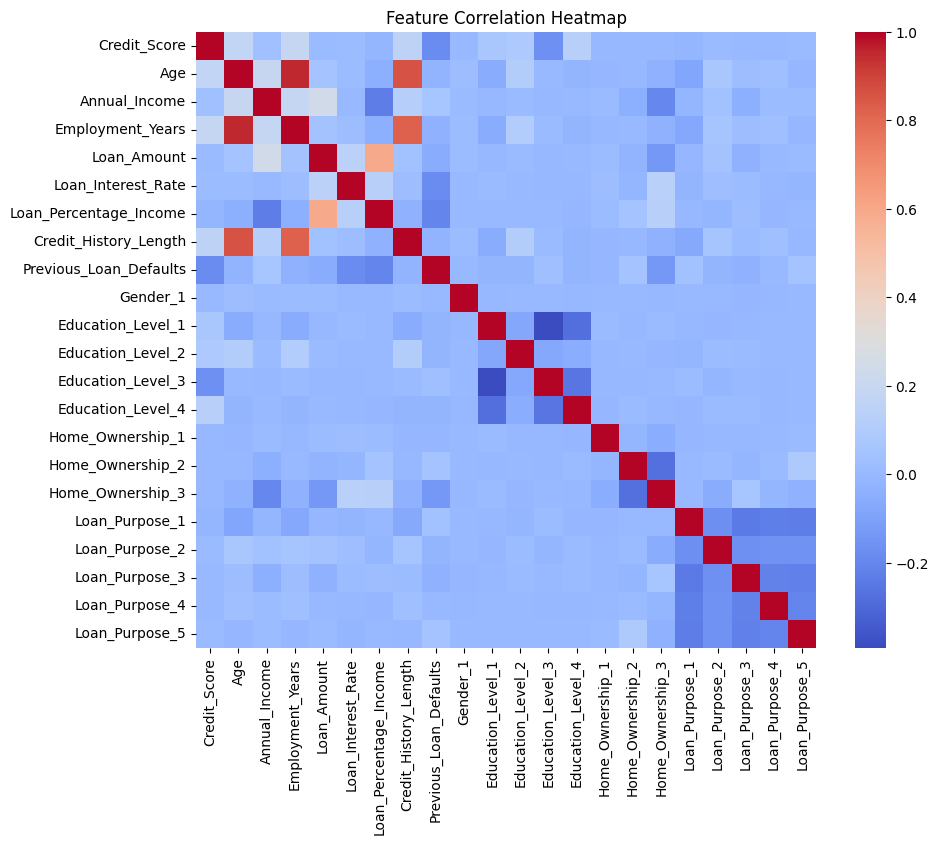

In [ ]:
# Drop Loan_Status if not used in clustering
#X_cluster = df_processed.drop(columns=[col for col in df_processed.columns if 'Loan_Status' in col])
# Keep only numeric columns for clustering

X_cluster = df_processed.select_dtypes(include=[np.number])
#Dimensionality Reduction
pca = PCA(n_components=2)  # or 2 for visualization
X_pca = pca.fit_transform(X_cluster)

df_processed['PCA1'] = X_pca[:, 0]
df_processed['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_cluster).corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

Cluster summary (from KMeans):
                    count        mean        std    min    25%    50%    75%  \
credit_risk_tier                                                               
0                 16528.0  621.388250  50.891007  390.0  589.0  629.0  660.0   
1                  4909.0  646.854960  46.376824  435.0  619.0  654.0  680.0   
2                  9353.0  629.035710  48.443696  418.0  599.0  636.0  665.0   
3                  3772.0  656.425239  48.923755  455.0  628.0  662.0  691.0   
4                 10438.0  638.270837  48.414586  444.0  609.0  645.0  674.0   

                    max  
credit_risk_tier         
0                 751.0  
1                 762.0  
2                 750.0  
3                 850.0  
4                 745.0  


,Credit_Score,credit_risk_tier,credit_risk_label,industry_risk_label
0,561,2,KMeans_Fair,FICO_Poor
1,504,0,KMeans_Poor,FICO_Poor
2,635,2,KMeans_Fair,FICO_Fair
3,675,2,KMeans_Fair,FICO_Good
4,586,2,KMeans_Fair,FICO_Fair
5,532,0,KMeans_Poor,FICO_Poor
6,701,2,KMeans_Fair,FICO_Good
7,585,2,KMeans_Fair,FICO_Fair
8,544,2,KMeans_Fair,FICO_Poor
9,640,0,KMeans_Poor,FICO_Fair



Comparison of KMeans clusters with industry-standard labels:
industry_risk_label  FICO_Excellent  FICO_Fair  FICO_Good  FICO_Poor  \
credit_risk_label                                                      
KMeans_Excellent                  3       1824       1591        286   
KMeans_Fair                       0       5909       1980       1462   
KMeans_Good                       0       6066       3019       1342   
KMeans_Poor                       0      10265       2898       3364   
KMeans_Very Good                  0       2742       1708        447   

industry_risk_label  FICO_Very Good  
credit_risk_label                    
KMeans_Excellent                 68  
KMeans_Fair                       2  
KMeans_Good                      11  
KMeans_Poor                       1  
KMeans_Very Good                 12  


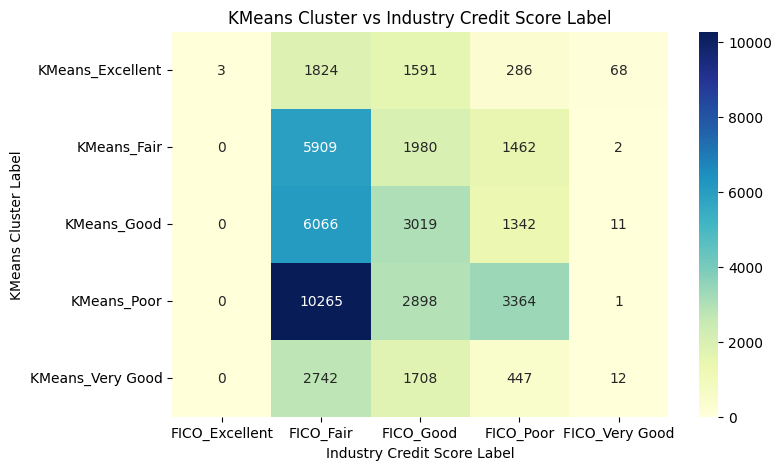


Adjusted Rand Index (ARI): 0.0141
Normalized Mutual Information (NMI): 0.0192


In [82]:
# Define the industry-standard credit score label function
def map_credit_score_to_label(score):
    if score >= 800:
        return 'FICO_Excellent'
    elif score >= 740:
        return 'FICO_Very Good'
    elif score >= 670:
        return 'FICO_Good'
    elif score >= 580:
        return 'FICO_Fair'
    else:
        return 'FICO_Poor'

# Copy actual credit scores into df_processed
df_processed['Credit_Score'] = df_formodel['Credit_Score'].values

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_processed['credit_risk_tier'] = kmeans.fit_predict(X_pca)

# Optional: analyze clusters
cluster_summary = df_processed.groupby('credit_risk_tier')['Credit_Score'].describe()
print("Cluster summary (from KMeans):")
print(cluster_summary)

# Mean score per cluster
cluster_means = df_processed.groupby('credit_risk_tier')['Credit_Score'].mean()

# Sort clusters by mean score (to assign consistent risk labels)
sorted_clusters = cluster_means.sort_values().index.tolist()

# Assign interpretive labels to clusters (optional, based on mean score ranking)
tier_labels = ['KMeans_Poor', 'KMeans_Fair', 'KMeans_Good', 'KMeans_Very Good', 'KMeans_Excellent']
cluster_to_label = {cluster: tier_labels[i] for i, cluster in enumerate(sorted_clusters)}
df_processed['credit_risk_label'] = df_processed['credit_risk_tier'].map(cluster_to_label)

# Industry-standard credit tier assignment (based on actual credit score)
df_processed['industry_risk_label'] = df_processed['Credit_Score'].apply(map_credit_score_to_label)


# Display final labeled credit data
display(df_processed[['Credit_Score', 'credit_risk_tier', 'credit_risk_label', 'industry_risk_label']].head(20))

# Optional: See how your clusters align with industry risk labels
cross_tab = pd.crosstab(df_processed['credit_risk_label'], df_processed['industry_risk_label'])
print("\nComparison of KMeans clusters with industry-standard labels:")
print(cross_tab)

# Visualize the crosstab as a heatmap for better interpretability
plt.figure(figsize=(8, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title("KMeans Cluster vs Industry Credit Score Label")
plt.xlabel("Industry Credit Score Label")
plt.ylabel("KMeans Cluster Label")
plt.show()


# Encode both sets of labels numerically
industry_encoded = LabelEncoder().fit_transform(df_processed['industry_risk_label'])
cluster_encoded = LabelEncoder().fit_transform(df_processed['credit_risk_label'])

# Compute clustering quality metrics
ari = adjusted_rand_score(industry_encoded, cluster_encoded)
nmi = normalized_mutual_info_score(industry_encoded, cluster_encoded)

print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


In [80]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_processed['PCA1'], df_processed['PCA2'], 
                      c=df_processed['credit_score_tier'], cmap='viridis', s=10)
plt.title('KMeans Clusters (Credit Score Tiers)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Tier Score')
plt.show()

KeyError: 'credit_score_tier'

<Figure size 800x600 with 0 Axes>

                  ApplicantIncome  LoanAmount  Credit_History
credit_risk_tier                                             
0                    10699.212963  223.453704        0.851852
1                     4261.606362  130.524851        0.838966
2                     6207.000000  139.333333        1.000000


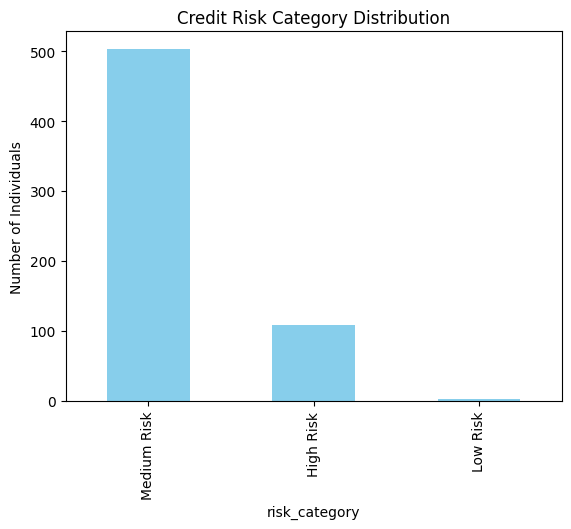

In [ ]:
# Group by cluster and see feature averages
cluster_summary = df_formodel.groupby('credit_risk_tier')[['ApplicantIncome', 'LoanAmount', 'Credit_History']].mean()
print(cluster_summary)

# Based on your analysis above, map clusters to scores
# Example: let's say cluster 0 = high risk, 1 = medium, 2 = low
cluster_to_score = {
    0: 500,  # High Risk
    1: 650,  # Medium Risk
    2: 750   # Low Risk
}

df_formodel['pseudo_credit_score'] = df_formodel['credit_risk_tier'].map(cluster_to_score)

cluster_to_label = {
    0: 'High Risk',
    1: 'Medium Risk',
    2: 'Low Risk'
}

df_formodel['risk_category'] = df_formodel['credit_risk_tier'].map(cluster_to_label)

# Visualize the distribution of risk categories
df_formodel['risk_category'].value_counts().plot(kind='bar', title='Credit Risk Category Distribution', color='skyblue')
plt.ylabel("Number of Individuals")
plt.show()


C:\Users\ivych\AppData\Local\Temp\ipykernel_37500\2556730079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_formodel, x='risk_category', y='Dependents', palette='viridis')


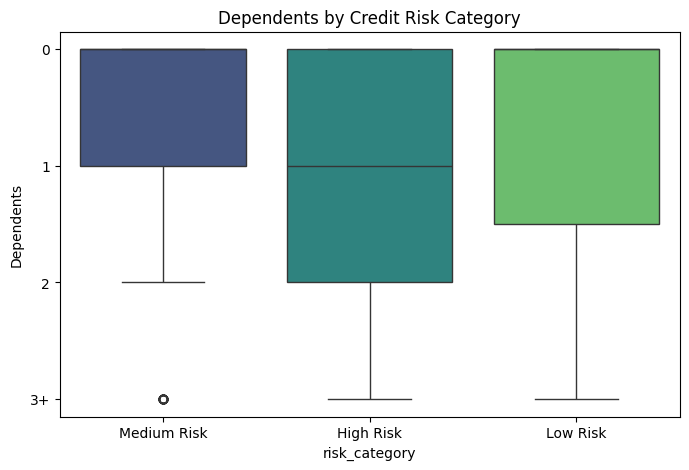

C:\Users\ivych\AppData\Local\Temp\ipykernel_37500\2556730079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_formodel, x='risk_category', y='LoanAmount', palette='magma')


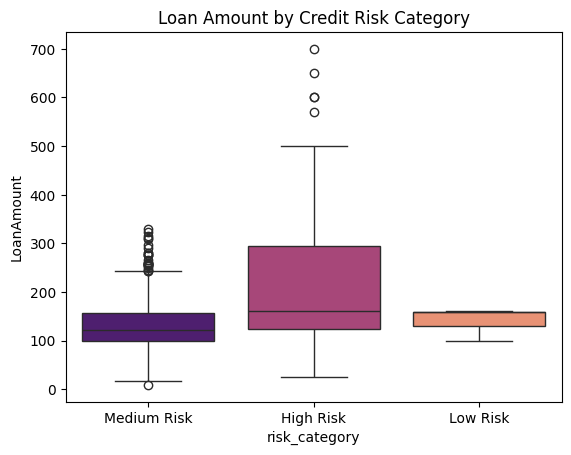

In [ ]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_formodel, x='risk_category', y='Dependents', palette='viridis')
plt.title("Dependents by Credit Risk Category")
plt.show()

sns.boxplot(data=df_formodel, x='risk_category', y='LoanAmount', palette='magma')
plt.title("Loan Amount by Credit Risk Category")
plt.show()

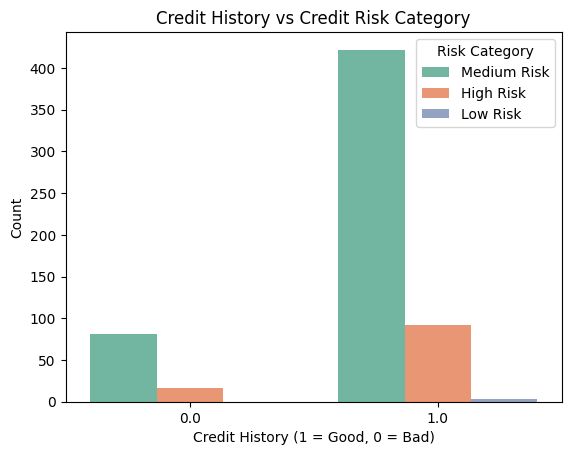

In [ ]:
sns.countplot(data=df_formodel, x='Credit_History', hue='risk_category', palette='Set2')
plt.title("Credit History vs Credit Risk Category")
plt.xlabel("Credit History (1 = Good, 0 = Bad)")
plt.ylabel("Count")
plt.legend(title="Risk Category")
plt.show()

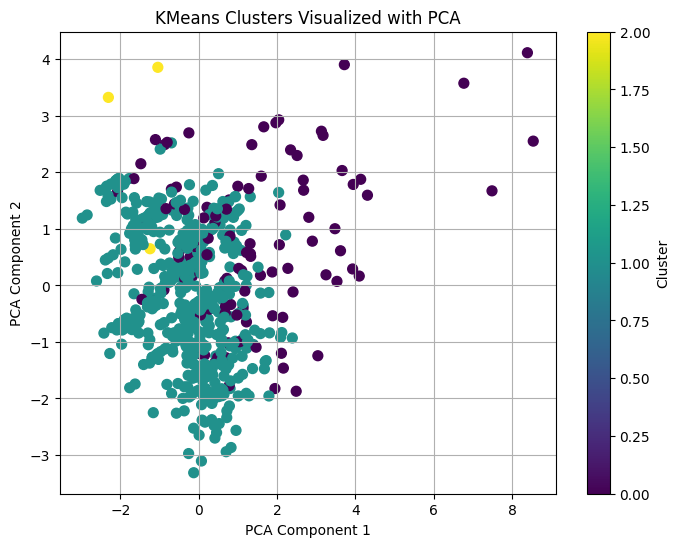

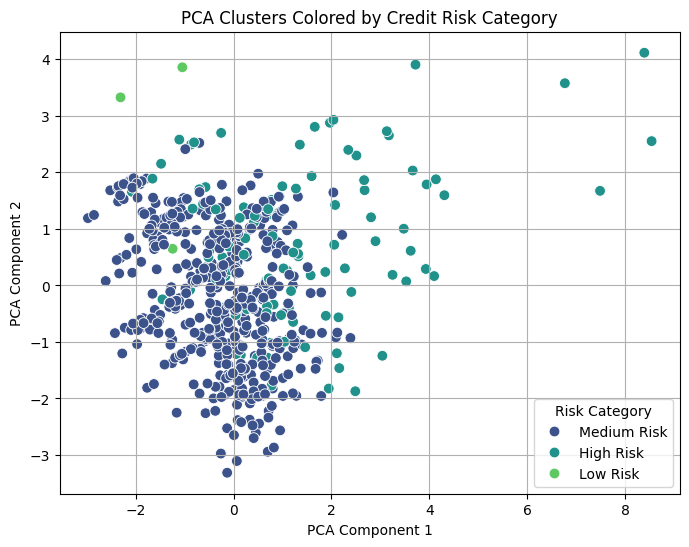

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2 for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_formodel['credit_risk_tier'], cmap='viridis', s=50)
plt.title('KMeans Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Assumes X_pca is your 2D PCA representation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_formodel['risk_category'], palette='viridis', s=60)
plt.title("PCA Clusters Colored by Credit Risk Category")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Risk Category')
plt.grid(True)
plt.show()